# Mislabeled examples detection on imbalanced datasets

Mislabeled detection is an important topic for datascientists to deal with the inherent imperfections in the labeling process of real world datasets. With current state-of-the-art methods, good-enough detection rates can be achived on balanced datasets with completly at random corruptions. However things can get trickier when datasets are imbalanced.

## The SMS dataset

Let's look at the SMS dataset, a text classification dataset which task is to detect SPAM sms from common sms.

In [456]:
from mislabeled.datasets.wrench import fetch_wrench
from sklearn.feature_extraction.text import TfidfVectorizer
from mislabeled.preprocessing import WeakLabelEncoder
import numpy as np

all = fetch_wrench("sms")
train = fetch_wrench("sms", split="train")
validation = fetch_wrench("sms", split="validation")
test = fetch_wrench("sms", split="test")

For every SMS, two set of labels are available, a ground truth label that can be used to diagnose mislabeled examples detectors, and weak labels that are computed thanks to labelling functions. These labelling functions works by checking if a certain list of keywords are present in the SMS, and assign a label if they matched. Note that labelling functions can chose to not return a label. Here is an example of a SMS from the dataset:

In [457]:
train["data"][0]

'goldviking (29/m) is inviting you to be his friend. reply yes-762 or no-762 see him: www.sms.ac/u/goldviking stop? send stop frnd to 62468'

And its associated ground truth label and weak labels:

In [458]:
train["target_names"], train["target"][0], train["weak_targets"][0]

(['ham', 'spam'],
 1,
 array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1,  1]))

This SMS was actually a SPAM and all labelling functions returned no labels (-1) except for the last one returning SPAM (1).

For simplicity we choose to preprocess the textual data with tf-idf where we chose to not count words that appears in less than 10 SMS:

In [459]:
tfidf = TfidfVectorizer(
    strip_accents="unicode", stop_words="english", min_df=5, max_df=0.5
).fit(all["data"])

X_train = tfidf.transform(train["data"]).astype(np.float32)
X_validation = tfidf.transform(validation["data"]).astype(np.float32)
X_test = tfidf.transform(test["data"]).astype(np.float32)

Now let's get our ground truth label:

In [460]:
y_train = train["target"]
y_validation = validation["target"]
y_test = test["target"]

To actually experiment with mislabeled examples detectors, we chose to aggregate the weak labels with majority vote to create a single weak label for each example:

In [461]:
seed = 24

In [462]:
wle = WeakLabelEncoder(random_state=seed).fit(train["weak_targets"])
y_noisy_train = wle.transform(train["weak_targets"])
y_noisy_validation = wle.transform(validation["weak_targets"])
y_noisy_test = wle.transform(test["weak_targets"])

For example, the noisy label of the SMS showed previously would be:

In [463]:
y_noisy_train[0]

1

Now that we have our noisy labels, we can check how much the dataset is actually imbalanced, with ground truth labels and noisy labels:

In [464]:
y = np.concatenate((y_train, y_validation))
y_noisy = np.concatenate((y_noisy_train, y_noisy_validation))

n_samples = y.shape[0]

np.bincount(y) / n_samples, np.bincount(y_noisy) / n_samples

(array([0.86570696, 0.13429304]), array([0.65213962, 0.34786038]))

Our first observation is that the actual dataset is way more imbalanced than the observed dataset. To see what's happening we can look at the *noise transition matrix* denoted by $\mathbf{T}$. Here, $\forall (i,j) \in [\![1,K]\!]^2$, where $K$ is the number of classes, $\mathbf{T}_{i,j}$ represents the probability $p(\tilde{Y}=j|Y=i)$ of an example from the class $i$ to have been assigned a noisy label from class $j$.

In [465]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_noisy, normalize="true")

array([[0.69339408, 0.30660592],
       [0.38619677, 0.61380323]])

We can see that the noise-generative process is mostly class independent as the out-flip probabilities of the two classes are mostly equals. Let's look more precisely if the noise generative process depends on the example thanks to a classifier 2 sample test (C2ST).

In [466]:
import scipy.sparse as sp
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, PredefinedSplit

classifier = SGDClassifier(loss="log_loss", random_state=seed)

X = sp.vstack((X_train, X_validation))
split = np.concatenate((-np.ones(X_train.shape[0]), np.zeros(X_validation.shape[0])))
is_noisy = y != y_noisy

cross_val_score(
    classifier, X, is_noisy, cv=PredefinedSplit(split), scoring="balanced_accuracy"
)

array([0.51305419])

From the results of the C2ST, it seems that the noise generative process is mostly non-dependent on the example features value. Now that we fully comprehend the task we have to deal with, let's dive in the world of mislabeled example detection.

## Mislabeled examples detection

Let's introduce one of the detectors from the family of model-based detectors based on the Area Under the Margin (AUM). The intuition behind the AUM detector is that models that can be trained progressively on a dataset (think about GBM or Neural Networks) will express different behaviour on three categorties of examples:
1. it will first learn easy examples
2. then hard but clean examples
3. finally overfit on noisy examples

This should be reflected on the margin of these categories of examples, with easy examples having a high margin during all training but mislabeled examples having at first a negative margin (because the label assigned by the model is different than the observed label) and the margin will become positive only when the noisy label is completly overfitted.

To rank the examples from the less to the most trustable, AUM integrates the margin along the training procedure of the model. At the end we should have clean examples with high trust scores (or high AUM) and mislabeled examples with low trust scores (or negative AUM).

In [467]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from mislabeled.detect.detectors import AreaUnderMargin

aum = AreaUnderMargin(classifier)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    aum_trust_scores = aum.trust_score(X, y_noisy)
aum_trust_scores

array([17.18931137, 20.07646759,  9.49562059, ..., 21.28000625,
       -6.01546604, 13.46524157])

To have an idea on the efficiency of AUM on the SMS dataset, we can look at ranking quality metrics such as the Area under the ROC Curve, to evaluate if the trust scores effectively rank the examples given their probability to be mislabeled.

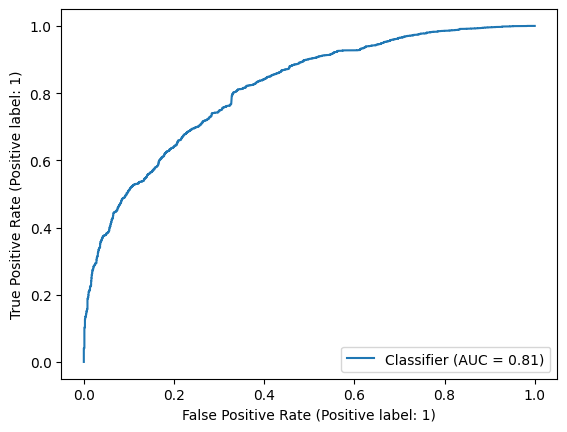

In [468]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y == y_noisy, aum_trust_scores)

With an AUC of $0.84$, AUM seems quite effective ! Now let's look at the performance of a classifier on the filtered dataset by AUM.

In [469]:
from sklearn.metrics import balanced_accuracy_score

n_runs = 10
n_splits = 200
splits = np.linspace(0, 0.9, num=n_splits)
aum_scores = np.empty((n_runs, n_splits))

for i in range(n_runs):
    classifier.set_params(random_state=seed + i)
    aum = AreaUnderMargin(classifier)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        aum_trust_scores = aum.trust_score(X, y_noisy)
    for j, split in enumerate(splits):
        classifier.set_params(random_state=seed + i * n_splits + j)
        filtered = aum_trust_scores >= np.quantile(aum_trust_scores, split)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            classifier.fit(X[filtered], y_noisy[filtered])
        aum_scores[i, j] = balanced_accuracy_score(y_test, classifier.predict(X_test))

Let's compute some baselines:
* gold : train dataset with ground truth labels
* silver : train dataset with noisy labels but perfect filtering (all noisy labels are removed)
* none : no filtering

In [470]:
gold = np.empty(n_runs)
silver = np.empty(n_runs)
none = np.empty(n_runs)

for i in range(n_runs):
    classifier.set_params(random_state=seed + i)

    gold[i] = balanced_accuracy_score(y_test, classifier.fit(X, y).predict(X_test))

    clean = y == y_noisy
    silver[i] = balanced_accuracy_score(
        y_test, classifier.fit(X[clean, :], y_noisy[clean]).predict(X_test)
    )

    none[i] = balanced_accuracy_score(
        y_test, classifier.fit(X, y_noisy).predict(X_test)
    )

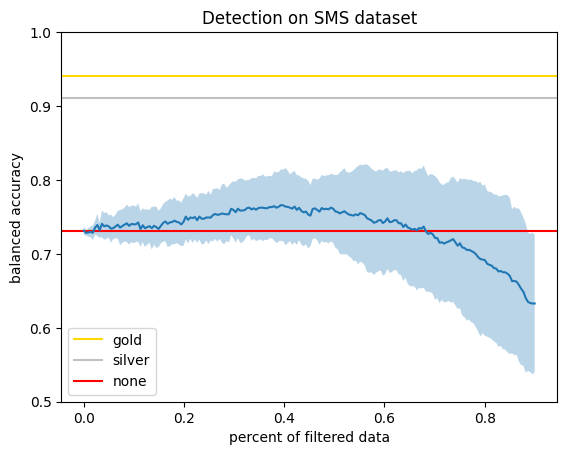

In [471]:
import matplotlib.pyplot as plt

plt.axhline(np.mean(gold), color="gold", label="gold")
plt.axhline(np.mean(silver), color="silver", label="silver")
plt.axhline(np.mean(none), color="red", label="none")
plt.plot(splits, np.mean(aum_scores, axis=0), label="AUM")
plt.fill_between(
    splits,
    np.mean(aum_scores, axis=0) + np.std(aum_scores, axis=0),
    np.mean(aum_scores, axis=0) - np.std(aum_scores, axis=0),
    alpha=0.3,
)
plt.xlabel("percent of filtered data")
plt.ylabel("balanced accuracy")
plt.title("Detection on SMS dataset")
plt.ylim((0.5, 1.0))
plt.legend()
plt.show()

What's happening ? After filtering the dataset we got performance close to doing nothing. Maybe AUM is not fitted for our case, let's try another detector Variance of Softmax's Gradients, Vo(S)G.

This detector is inspired from the litterature of explainability and suppose that mislabeled examples will have also noisy explanations for their predictions.

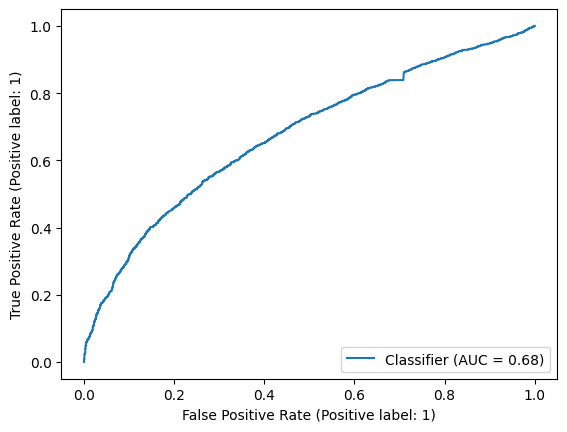

In [472]:
from mislabeled.detect.detectors import LinearVoSG

vosg = LinearVoSG(classifier)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    vosg_trust_scores = vosg.trust_score(X, y_noisy)

RocCurveDisplay.from_predictions(y == y_noisy, vosg_trust_scores)

Oh the AUC for VoSG is way worse than AUM, quite close to random. But does the filtered classifier performs even worse also ?

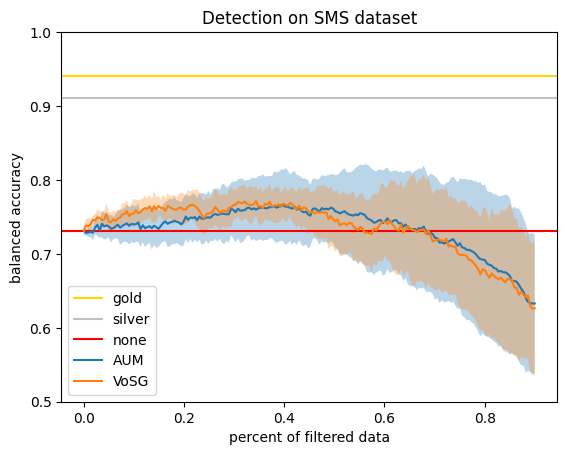

In [473]:
vosg_scores = np.empty((n_runs, n_splits))

for i in range(n_runs):
    classifier.set_params(random_state=seed + i)
    vosg = LinearVoSG(classifier)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        vosg_trust_scores = vosg.trust_score(X, y_noisy)
    for j, split in enumerate(splits):
        classifier.set_params(random_state=seed + i * n_splits + j)
        filtered = vosg_trust_scores >= np.quantile(vosg_trust_scores, split)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            classifier.fit(X[filtered], y_noisy[filtered])
        vosg_scores[i, j] = balanced_accuracy_score(y_test, classifier.predict(X_test))

plt.axhline(np.mean(gold), color="gold", label="gold")
plt.axhline(np.mean(silver), color="silver", label="silver")
plt.axhline(np.mean(none), color="red", label="none")
plt.plot(splits, np.mean(aum_scores, axis=0), label="AUM")
plt.fill_between(
    splits,
    np.mean(aum_scores, axis=0) + np.std(aum_scores, axis=0),
    np.mean(aum_scores, axis=0) - np.std(aum_scores, axis=0),
    alpha=0.3,
)
plt.plot(splits, np.mean(vosg_scores, axis=0), label="VoSG")
plt.fill_between(
    splits,
    np.mean(vosg_scores, axis=0) + np.std(vosg_scores, axis=0),
    np.mean(vosg_scores, axis=0) - np.std(vosg_scores, axis=0),
    alpha=0.3,
)
plt.xlabel("percent of filtered data")
plt.ylabel("balanced accuracy")
plt.title("Detection on SMS dataset")
plt.legend()
plt.ylim((0.5, 1.0))
plt.show()

Quite surprisingly it performs way better, with low variance when the less trusted examples are filtered out. What's happening ? I'm going to help you by giving you a clue.

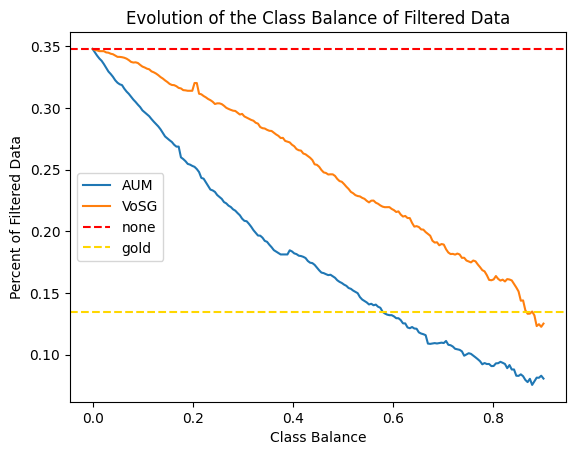

In [474]:
def ratios(y, scores, splits):
    r = np.empty_like(splits)
    for i, split in enumerate(splits):
        filtered = scores >= np.quantile(scores, split)
        r[i] = np.bincount(y[filtered])[1] / np.sum(filtered)
    return r


plt.plot(splits, ratios(y_noisy, aum_trust_scores, splits), label="AUM")
plt.plot(splits, ratios(y_noisy, vosg_trust_scores, splits), label="VoSG")
plt.axhline(
    np.bincount(y_noisy)[1] / y_noisy.shape[0],
    color="red",
    linestyle="--",
    label="none",
)
plt.axhline(np.bincount(y)[1] / y.shape[0], color="gold", linestyle="--", label="gold")
plt.xlabel("Class Balance")
plt.ylabel("Percent of Filtered Data")
plt.title("Evolution of the Class Balance of Filtered Data")
plt.legend()
plt.show()

Yes it seems that the two detectors does not filter out at the same speed the two classes, AUM filters more aggresively the minority class than VoSG. To better see this phenomemon, we can look at the ROC curve of the trust scores of both method class per class.

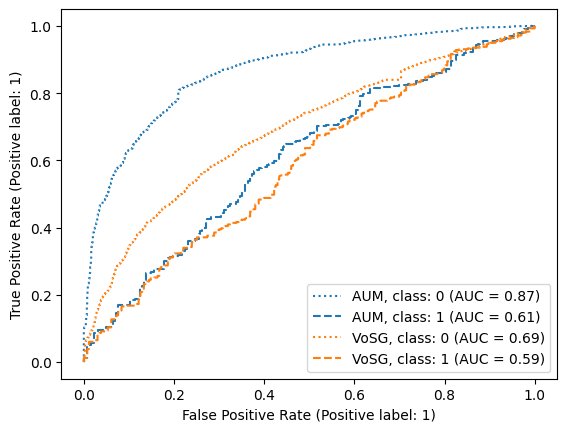

In [475]:
fig, ax = plt.subplots()

for name, trust_scores, color in [
    ("AUM", aum_trust_scores, "blue"),
    ("VoSG", vosg_trust_scores, "orange"),
]:
    for ls, c in zip([":", "--"], np.unique(y)):
        RocCurveDisplay.from_predictions(
            y[y == c] == y_noisy[y == c],
            trust_scores[y == c],
            name=f"{name}, class: {c}",
            ax=ax,
            linestyle=ls,
            color=f"tab:{color}",
        )

plt.show()

It seems that, even though AUC of both classes for VoSG are low, it effectively better ranks the most trustable examples from class 1. Mislabeled detection in datasets with class imbalanced is a problem not studied that much, but one improvement we can make to our detectors is to "adjust" their outputed probabilities before probing them (computing margin or gradients). Instead of probing the model using the predicted probability, we look at the deviation from the predicted probability to the mean predicted probability for all example of the observed class.

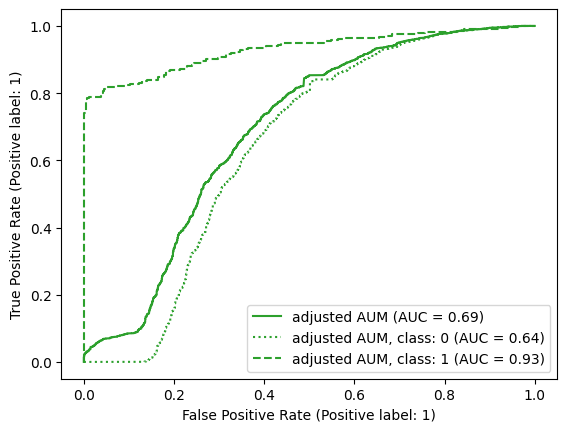

In [476]:
from mislabeled.detect import ModelBasedDetector
from mislabeled.ensemble import ProgressiveEnsemble

adjusted_aum = ModelBasedDetector(
    classifier, ProgressiveEnsemble(), "adjusted_soft_margin", "sum"
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    adjusted_aum_trust_scores = adjusted_aum.trust_score(X, y_noisy)

fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    y == y_noisy,
    adjusted_aum_trust_scores,
    color="tab:green",
    name="adjusted AUM",
    ax=ax,
)
for ls, c in zip([":", "--"], np.unique(y)):
    RocCurveDisplay.from_predictions(
        y[y == c] == y_noisy[y == c],
        adjusted_aum_trust_scores[y == c],
        name=f"adjusted AUM, class: {c}",
        ax=ax,
        linestyle=ls,
        color=f"tab:green",
    )

plt.show()

With adjusted probabilities, mislabeled examples from class 1 are exceptionnaly well detected, but at the detriment of examples from class 0. What's the impact on the filtered classifier ?

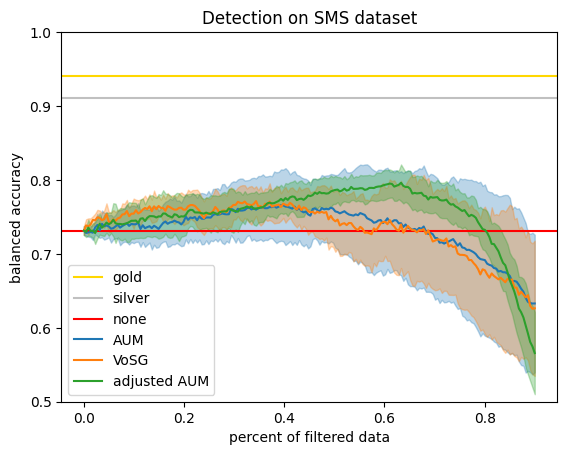

In [477]:
adjusted_aum_scores = np.empty((n_runs, n_splits))

for i in range(n_runs):
    classifier.set_params(random_state=seed + i)
    adjusted_aum = ModelBasedDetector(
        classifier, ProgressiveEnsemble(), "adjusted_soft_margin", "sum"
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        adjusted_aum_trust_scores = adjusted_aum.trust_score(X, y_noisy)
    for j, split in enumerate(splits):
        classifier.set_params(random_state=seed + i * n_splits + j)
        filtered = adjusted_aum_trust_scores >= np.quantile(
            adjusted_aum_trust_scores, split
        )
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            classifier.fit(X[filtered], y_noisy[filtered])
        adjusted_aum_scores[i, j] = balanced_accuracy_score(
            y_test, classifier.predict(X_test)
        )

plt.axhline(np.mean(gold), color="gold", label="gold")
plt.axhline(np.mean(silver), color="silver", label="silver")
plt.axhline(np.mean(none), color="red", label="none")
for s, l, c in [
    (aum_scores, "AUM", "blue"),
    (vosg_scores, "VoSG", "orange"),
    (adjusted_aum_scores, "adjusted AUM", "green"),
]:
    plt.plot(splits, np.mean(s, axis=0), label=l, color=f"tab:{c}")
    plt.fill_between(
        splits,
        np.mean(s, axis=0) + np.std(s, axis=0),
        np.mean(s, axis=0) - np.std(s, axis=0),
        alpha=0.3,
        color=f"tab:{c}",
    )

plt.xlabel("percent of filtered data")
plt.ylabel("balanced accuracy")
plt.title("Detection on SMS dataset")
plt.legend()
plt.ylim((0.5, 1.0))
plt.show()